In [2]:
import torch
from torch import nn
from d2l import torch as d2l



## 定义模型

In [24]:
def relu(X):
    Z = torch.zeros_like(X)
    return torch.max(Z, X)

class Model:
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        self.W_1 = torch.normal(0, 0.01, (num_inputs, num_hiddens), requires_grad=True)
        self.b_1 = torch.zeros(num_hiddens, requires_grad=True)
        self.W_2 = torch.normal(0, 0.01, (num_hiddens, num_outputs), requires_grad=True)
        self.b_2 = torch.zeros(num_outputs, requires_grad=True)
        self.num_inputs = num_inputs

    def __call__(self, X):
        # X: [batch_size, channels, width, height]
        X = X.reshape((-1, self.num_inputs))
        H = relu(X @ self.W_1 + self.b_1)
        O = H @ self.W_2 + self.b_2
        return O

    def get_params(self):
        return [self.W_1, self.b_1, self.W_2, self.b_2]

## 定义损失函数

In [11]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


print(cross_entropy(torch.tensor([[0.3, 0.7], [0.3, 0.6]]), torch.tensor([1, 0])))

tensor([0.3567, 1.2040])


## 定义优化器

In [28]:
class Optimizer:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size):
        return d2l.sgd(self.params, self.lr, batch_size)

## 其它函数

In [33]:
def accuracy(y_hat, y):
    y.reshape(-1)
    count = 0
    for prob_dis, label in zip(y_hat, y):
        predict = prob_dis.argmax(dim=0)
        count += int(predict == label)
    return count

def evaluate(model, test_iter):
    if isinstance(model, torch.nn.Module):
        model.eval()
    metric = d2l.Accumulator(2)
    for X, y in test_iter:
        y_hat = model(X)
        metric.add(accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

accuracy(torch.tensor([[0.1, 0.3, 0.4], [0.3, 0.5, 0.4]]), torch.tensor([1, 1])) / 2

def train_epoch_ch3(model, train_iter, loss_fn, optimizer):
    if isinstance(model, torch.nn.Module):
        model.train()
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        if isinstance(optimizer, torch.optim.Optimizer):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            metric.add(loss * len(y), accuracy(y_hat, y), y.numel())
        else:
            loss.sum().backward()
            optimizer(X.shape[0])
            metric.add(float(loss.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(model, train_iter, test_iter, loss_fn, num_epochs, optimizer):
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch_ch3(model, train_iter, loss_fn, optimizer)
        test_acc = evaluate(model, test_iter)
        animator.add(epoch + 1, (train_loss, train_acc, test_acc))



## 开始训练

RuntimeError: grad can be implicitly created only for scalar outputs

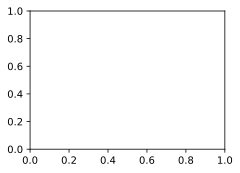

RuntimeError: grad can be implicitly created only for scalar outputs

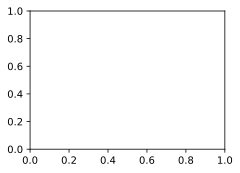

In [34]:
num_inputs = 784
num_hiddens = 256
num_outputs = 10
lr = 0.1
batch_size = 256
num_epochs = 10

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
model = Model(num_inputs, num_hiddens, num_outputs)
loss_fn = cross_entropy
optimizer = torch.optim.SGD(model.get_params(), lr)

train_ch3(model, train_iter, test_iter, loss_fn, num_epochs, optimizer)

## pytorch实现

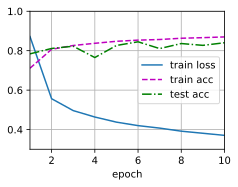

In [19]:
num_inputs = 784
num_hiddens = 256
num_outputs = 10
batch_size = 256
num_epochs = 10
lr = 0.1

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(num_inputs, num_hiddens),
    torch.nn.ReLU(),
    torch.nn.Linear(num_hiddens, num_outputs)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

train_ch3(model, train_iter, test_iter, loss_fn, num_epochs, optimizer)